# A paper study(Motivation example 1-LP)
Li, Z., Ding, R., & Floudas, C. A. (2011). A comparative theoretical and computational study on robust counterpart optimization: I. Robust linear optimization and robust mixed integer linear optimization. Industrial &amp; Engineering Chemistry Research, 50(18), 10567–10603. https://doi.org/10.1021/ie200150p


## A generic formulation:

\begin{align*}
    \textbf{max} & \sum_{j} c_{j}x_{j} \\
    s.t. & \sum_{j} a_{i,j} x_{j} \le b_{i} \quad \forall i \in I\\
    & x_j \ge 0 \\
\end{align*}


## Motivating example 1

\begin{align*}
    \textbf{max} & 8x_1 + 12x_2 \\
    s.t. & \tilde {a}_{11} x_1 + \tilde {a}_{12} x_2 \le 140 \\
    & \tilde {a}_{21} x_1 + \tilde {a}_{22} x_2 \le 72 \\
    & x_1, x_2 \ge 0 \\
\end{align*}

Where

\begin{align*}
    &\tilde{a}_{11} = 10 + \xi_{11} , \quad &&\tilde{a}_{12} = 20 + 2\xi_{12} \\
    &\tilde{a}_{11} = 6 + 0.6\xi_{21} , \quad &&\tilde{a}_{22} = 8 + 0.8\xi_{22} \\
\end{align*}

for independent random varibales $\xi_{11}$, $\xi_{12}$, $\xi_{21}$, $\xi_{22}$ in [-1, 1\] (10\% perturbation).

In [14]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve

In [ ]:
# Implementation of the deterministic form without uncertainty

m1 = ConcreteModel()
m1.i = Set(initialize=[1,2], doc='Constraint index')
m1.j = Set(initialize=[1,2], doc='Variable index')
m1.a = Param(m1.i, m1.j, initialize={(1,1): 10, (1,2):20, (2,1):6, (2,2):8}, doc='Variable coef')
m1.b = Param(m1.i, initialize={1: 140, 2: 72}, doc='Variable coef')
m1.c = Param(m1.j, initialize={1: 8, 2: 12}, doc='Objective coef')

m1.x = Var(m1.j, domain=NonNegativeReals)

def c_rule(model, i):
    return sum(model.a[i,j] * model.x[j] for j in model.j) <= model.b[i]

m1.constraints = Constraint(m1.i, rule=c_rule)


m1.obj = Objective(expr = sum(m1.c[j] * m1.x[j] for j in m1.j), sense=maximize)

def solve_with_gams(m):
    opt1 = SolverFactory('gams')
    io_options = dict()

    io_options['solver'] = "cplex"
    res1 = opt1.solve(m,
        tee=True,
        add_options = ['option reslim=1000; option optcr=0.0;'],
        io_options=io_options)
    return res1

def solve_with_gurobi(m):
    opt1 = SolverFactory("gurobi_persistent")
    opt1.set_instance(m)
    res1 = opt1.solve()
    return res1

solve_with_gams(m1)
m1.x.pprint()

In [ ]:
m1.constraints.pprint()

In [ ]:
x1opt = value(m1.x[1])
x2opt = value(m1.x[2])

## Drawing the boundary
Xs = np.linspace(0, 15, 200)

# Calculate the values from both constraints
y1 = [(140-10*xs)/20 for xs in Xs]
y2 = [(72-6*xs)/8 for xs in Xs]

# Choose the minimum value for each xs
ymins = [min(y1_val, y2_val) for y1_val, y2_val in zip(y1, y2)]

plt.plot(Xs, ymins, label="Feasibility frontier")
plt.scatter(x1opt, x2opt, label="optimum")
plt.legend()
plt.ylim(0,10)
plt.xlim(0,12)
value(m1.obj)

## A generic robust version with uncertainty in $a_{ij}$

Notation:

\begin{align*}
    &\tilde {a}_{ij} = a_{i,j} + \xi_{i,j} \hat a_{i,j} \quad \forall j \in J \\
    &\tilde {b}_{i} = b_i + \xi_{i,0} \hat b_{i}
\end{align*}

For a generic LP with no objective uncertainty

\begin{align*}
    \textbf{max} & \sum_{j} c_{j}x_{j} \\
    s.t. & \sum_{j} a_{i,j} x_{j} + \underset{{\xi \in U}}{\textbf{max}}\{ -\xi_{i,0} \hat{b_i} + \sum_{j \in J} \xi_{i,j} \hat a_{i,j} x_{j} \}  \le b_{i} \quad \forall i \in I\\
    & x_j \ge 0 \\
\end{align*}


## Box uncertainty set

$$ U_{\infty} = \{ |\xi_j| \le \Psi, \forall j \in J \} $$

## A naive way using epsilon constraint

\begin{align*}
    \textbf{max} & \sum_{j} c_{j}x_{j} \\
    s.t. & \sum_{j} a_{i,j} x_{j} + \epsilon_i \le b_{i} \quad \forall i \in I\\
    & -\xi_{i,0} \hat{b_i} + \sum_{j \in J} \xi_{i,j} \hat a_{i,j} x_{j} \le \epsilon_i \quad \forall i \in I \\
    & x_j \ge 0 \\
\end{align*}

In [ ]:
# An implementation of the LHS box uncertainty
# A naive way using epsilon constraint(Not the one derived from the paper)

m2 = ConcreteModel()
m2.i = Set(initialize=[1,2], doc='Constraint index')
m2.j = Set(initialize=[1,2], doc='Variable index')
m2.a = Param(m2.i, m2.j, initialize={(1,1): 10, (1,2):20, (2,1):6, (2,2):8}, doc='Variable coef')
m2.b = Param(m2.i, initialize={1: 140, 2: 72}, doc='Variable coef')
m2.c = Param(m2.j, initialize={1: 8, 2: 12}, doc='Objective coef')

m2.xi = Param(m2.i, m2.j, initialize=1, within=(0,1), doc='random variables bounded from -1 to 1')
m2.ahat = Param(m2.i, m2.j, initialize={(1,1): 1, (1,2):2, (2,1):0.6, (2,2):0.8}, doc='maximum perturbation for a')

m2.x = Var(m2.j, domain=NonNegativeReals)

m2.eps = Var(m2.i, domain=Reals, doc='auxilary variables for the nested max')

def c_rule(model, i):
    return sum(model.a[i,j] * model.x[j] for j in model.j) + model.eps[i] <= model.b[i]
m2.constraints = Constraint(m2.i, rule=c_rule)

def aux_rule(model, i):
    return sum(model.xi[i,j] * model.ahat[i,j] * model.x[j] for j in model.j) <= model.eps[i]
m2.aux_constraints = Constraint(m2.i, rule=aux_rule)

m2.obj = Objective(expr = sum(m2.c[j] * m2.x[j] for j in m2.j), sense=maximize)

solve_with_gams(m2)

value(m2.obj)

In [ ]:
x1opt = value(m2.x[1])
x2opt = value(m2.x[2])

## Drawing the boundary
Xs = np.linspace(0, 15, 200)

# Calculate the values from both constraints
y1ref = [(140 - 10*xs) / 20 for xs in Xs]
y2ref = [(72 - 6*xs) / 8 for xs in Xs]

# Choose the minimum value for each xs
ymins_ref = [min(y1_val, y2_val) for y1_val, y2_val in zip(y1ref, y2ref)]

plt.plot(Xs, ymins_ref, label="Feasibility frontier(ref)")
plt.scatter(x1opt, x2opt, label="optimum")
plt.legend()
plt.ylim(0,10)
plt.xlim(0,12)
m2.x.pprint()
value(m2.obj)

## Using the derived RO counterpart (Eq 4.2)

\begin{align*}
    \textbf{max} & \sum_{j} c_{j}x_{j} \\
    s.t. & \sum_{j} a_{i,j} x_{j} + [ \Psi \sum_{j \in J} \hat a_{i,j} |x_j| ] \le b_{i} \quad \forall i \in I\\
    & x_j \ge 0 \\
\end{align*}



In [ ]:
# An implementation of the LHS box uncertainty using Eq 4.2

m3 = ConcreteModel()
m3.i = Set(initialize=[1,2], doc='Constraint index')
m3.j = Set(initialize=[1,2], doc='Variable index')
m3.a = Param(m3.i, m3.j, initialize={(1,1): 10, (1,2):20, (2,1):6, (2,2):8}, doc='Variable coef')
m3.b = Param(m3.i, initialize={1: 140, 2: 72}, doc='Variable coef')
m3.c = Param(m3.j, initialize={1: 8, 2: 12}, doc='Objective coef')

m3.ahat = Param(m3.i, m3.j, initialize={(1,1): 1, (1,2):2, (2,1):0.6, (2,2):0.8}, doc='maximum perturbation for a')
m3.Psi = Param(initialize=1)

m3.x = Var(m3.j, domain=NonNegativeReals)

def c_rule(model, i):
    return sum(model.a[i,j] * model.x[j] for j in model.j) + (model.Psi * sum(model.ahat[i,j] * model.x[j] for j in model.j)) <= model.b[i]
m3.constraints = Constraint(m3.i, rule=c_rule)

m3.obj = Objective(expr = sum(m3.c[j] * m3.x[j] for j in m3.j), sense=maximize)

m3.x[1].fix(80/11)
m3.x[2].fix(30/11)

solve_with_gams(m3)

m3.x.pprint()
value(m3.obj)
m3.constraints[1].pprint()

To draw the boundary, consider:

\begin{align*}
    \textbf{max} & 8x_1 + 12x_2 \\
    s.t. & 10 x_1 + 20 x_2 + \Psi (x_1 + 2x_2) \le 140 \\
    & 6 x_1 + 8 x_2 + \Psi (0.6x_1 + 0.8x_2) \le 72 \\
    & x_1, x_2 \ge 0 \\
\end{align*}

For generality, use scipy to solve at each x.



90.9090909090909

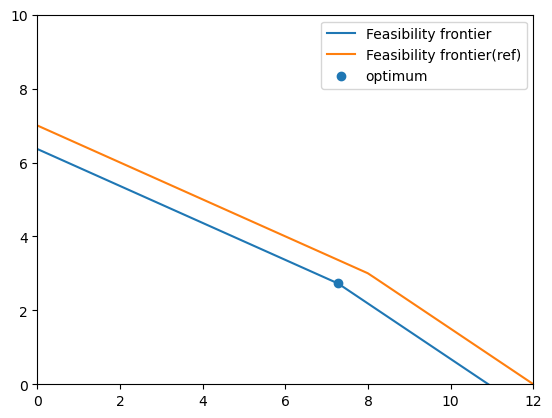

In [21]:
x1opt = value(m3.x[1])
x2opt = value(m3.x[2])

Psi = 1
Xs = np.linspace(0, 15, 200)

# Define the constraints' functions
def f_c1(x2, x1):
    return 10*x1 + 20*x2 + Psi * (x1 + 2*x2) - 140

def f_c2(x2, x1):
    return 6*x1 + 8*x2 + Psi * (0.6*x1 + 0.8*x2) - 72

y1 = [fsolve(f_c1, 0, args=(x,))[0] for x in Xs]
y2 = [fsolve(f_c2, 0, args=(x,))[0] for x in Xs]

# Calculate the values from both constraints
y1ref = [(140 - 10*xs) / 20 for xs in Xs]
y2ref = [(72 - 6*xs) / 8 for xs in Xs]
#
# Choose the minimum value for each xs
ymins_ref = [min(y1_val, y2_val) for y1_val, y2_val in zip(y1ref, y2ref)]
ymins = [min(y1_val, y2_val) for y1_val, y2_val in zip(y1, y2)]

plt.plot(Xs, ymins, label="Feasibility frontier")
plt.plot(Xs, ymins_ref, label="Feasibility frontier(ref)")
plt.scatter(x1opt, x2opt, label="optimum")
plt.legend()
plt.ylim(0,10)
plt.xlim(0,12)
value(m3.obj)